# Profast Data Analysis

This notebook is divided into two main sections:
1. [Data and Correlation Analysis and Preprocessing](http://localhost:8888/notebooks/tasrif/test_scripts/ProfastDataAnalysis.ipynb#1.-Data-and-Correlation-Analysis-and-Preprocessing)
2. [Machine Learning for CGM Prediction](http://localhost:8888/notebooks/tasrif/test_scripts/ProfastDataAnalysis.ipynb#2---Machine-Learning-for-CGM-Prediction)

## 1. Data and Correlation Analysis and Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from dataprep.eda import create_report
import seaborn as sns
import matplotlib.pyplot as plt

from tasrif.data_readers.siha_dataset import \
    SihaSleepDataset, \
    SihaStepsIntradayDataset, \
    SihaCaloriesIntradayDataset, \
    SihaDistanceIntradayDataset, \
    SihaHeartRateIntradayDataset, \
    SihaVeryActiveMinutesDataset, \
    SihaLightlyActiveMinutesDataset, \
    SihaSedentaryMinutesDataset, \
    SihaModeratelyActiveMinutesDataset, \
    SihaTimeInHeartRateZonesDataset, \
    SihaStepsDataset, \
    SihaCaloriesDataset, \
    SihaDistanceDataset, \
    SihaCgmDataset, \
    SihaEmrDataset, \
    SihaSleepIntradayDataset



from tasrif.processing_pipeline import ProcessingPipeline
from tasrif.processing_pipeline.pandas import ResetIndexOperator
from tasrif.processing_pipeline.pandas import DropFeaturesOperator
from tasrif.processing_pipeline.pandas import DropDuplicatesOperator
from tasrif.processing_pipeline.pandas import DropNAOperator
from tasrif.processing_pipeline.pandas import RenameOperator
from tasrif.processing_pipeline.pandas import GroupbyOperator
from tasrif.processing_pipeline.pandas import SumOperator
from tasrif.processing_pipeline.pandas import CorrOperator
from tasrif.processing_pipeline.pandas import MeanOperator
from tasrif.processing_pipeline.pandas import SetIndexOperator
from tasrif.processing_pipeline.pandas import ApplyOperator
from tasrif.processing_pipeline.pandas import AsTypeOperator
from tasrif.processing_pipeline.pandas import PivotOperator
from tasrif.processing_pipeline.pandas import RollingOperator
from tasrif.processing_pipeline.pandas import MergeOperator
from tasrif.processing_pipeline.custom import ResampleOperator
from tasrif.processing_pipeline.custom import SetFeaturesValueOperator
from tasrif.processing_pipeline.custom import CreateFeatureOperator
from tasrif.processing_pipeline.custom import AggregateOperator



NumExpr defaulting to 8 threads.


Change the path below to where the data actually is

In [2]:
profast_datapath='../../data/profast2020/'
profast_datapath='../../../'

Generate data similar to SIHA

In [3]:
patientID = np.linspace(0.0, 5.0, num=1000, endpoint=False).astype(int)

time = pd.date_range(start='2018-01-01', periods=1000, freq='15min')

mu = 72
sigma = 5
heartrate = np.random.normal(mu, sigma, 1000)

level = [1 for x in range(500)]
level.extend([0 for x in range(500)])

mu = 240
sigma = 150
mets = np.random.normal(mu, sigma, 1000)

mu = 30
sigma = 18
calories = np.random.normal(mu, sigma, 1000)

mu = 80
sigma = 184
steps = np.random.normal(mu, sigma, 1000)

mu = 0.03
sigma = 0.09
distance = np.random.normal(mu, sigma, 1000)

mu = 135
sigma = 45
cgm = np.random.normal(mu, sigma, 1000)

ramadan = [0 for x in range(700)]
ramadan.extend([1 for x in range(300)])

data = {
    'patientID': patientID, 
    'time': time, 
    'HeartRate': heartrate, 
    'level': level, 
    'mets': mets, 
    'Calories': calories, 
    'Steps': steps, 
    'Distance': distance, 
    'CGM': cgm, 
    'Ramadan': ramadan,
}

df = pd.DataFrame(data=data)

In [4]:
df

patientID                time  HeartRate  level        mets   Calories  \
0            0 2018-01-01 00:00:00  77.503899      1  -32.983979  11.915563   
1            0 2018-01-01 00:15:00  75.629189      1  310.578244  42.085818   
2            0 2018-01-01 00:30:00  74.241874      1  311.030321  50.409845   
3            0 2018-01-01 00:45:00  70.507811      1  288.937675  45.696715   
4            0 2018-01-01 01:00:00  66.746869      1  389.407110  51.258090   
..         ...                 ...        ...    ...         ...        ...   
995          4 2018-01-11 08:45:00  67.241023      0 -121.908875   1.601652   
996          4 2018-01-11 09:00:00  72.020840      0  315.173511   5.264682   
997          4 2018-01-11 09:15:00  70.862559      0  511.889462  37.274202   
998          4 2018-01-11 09:30:00  67.866740      0  114.220185  55.316257   
999          4 2018-01-11 09:45:00  62.923386      0  186.124226  21.809511   

          Steps  Distance         CGM  Ramadan  
0    -25.629221  0.006473  272.246015        0  
1      3.302188 -0.190694  148.751959        0  
2   -177.162157  0.165554  166.121082        0  
3   -232.937667  0.238466   79.343228        0  
4    221.194021 -0.044368  183.624662        0  
..          ...       ...         ...      ...  
995  -86.747216  0.112752   87.300166        1  
996 -281.356300 -0.000095  125.020228        1  
997   45.832353  0.147540  174.273185        1  
998  -14.469896  0.109052  224.470745        1  
999 -100.256144  0.092617  135.494968        1  

[1000 rows x 10 columns]

Below, we defined a set of helper functions for the analysis.
Some of them could be eventually integrated back to Tasrif

In [5]:
# Helper functions
def read_data(module, class_name_mapping, datapath=profast_datapath):
    ds = module(folder=datapath)

    pipeline = []
    
    
    df_tmp = ds.processed_dataframe()
    pipeline.append(ResetIndexOperator())

    if "time" not in df_tmp:
        pipeline.append(RenameOperator(columns={"dateTime": "time"}))

    pipeline.append(RenameOperator(columns={"value": class_name_mapping[module]}))
    
    pipeline = ProcessingPipeline(pipeline)
    df_tmp = pipeline.process(df_tmp)[0]
    return df_tmp


def ramadan_flag(t, start_ramadan=pd.Timestamp(2020, 4, 23, 0, 0, 0),
                 end_ramadan=pd.Timestamp(2020, 5, 23, 23, 59, 59)):

    if (t >= start_ramadan) & (t <= end_ramadan):
        return 1
    elif t < start_ramadan:
        return 0
    else:
        return 2

def get_participant(df, pid):
    return df[df["patientID"] == pid]

def get_before_ramadan(df):
    return df[df["Ramadan"] == 0]

def get_ramadan(df):
    return df[df["Ramadan"] == 1]

def corr_per_day(df):
    pipeline = []
    pipeline.append(GroupbyOperator(by=pd.Grouper(key='time',freq='D'), 
                                    select=["Calories", "mets", "Steps", "Distance", "CGM"]))
    pipeline.append(CorrOperator())
    
    pipeline = ProcessingPipeline(pipeline)
    df = pipeline.process(df)[0]
    return df

def get_data_day(df, month, day, time_col="time"):
    return df[(df[time_col].dt.month == month) & (df[time_col].dt.day == day)]

def drop_days_below_min_steps(df, min_steps=1000, time_col="time", pid_col="patientID"):
    # Get number of steps in a day
    
    total_steps_day = ProcessingPipeline([
        GroupbyOperator(by=[pid_col, pd.Grouper(key=time_col,freq='D')], select=["Steps"]),
        SumOperator()
    ]).process(df_intra)[0]

    total_steps_day = total_steps_day['Steps']

    # Find the <pids, days> to drop
    days_to_drop = total_steps_day[total_steps_day <= min_steps].index

    # Temporarily reindex dataframe with <pid, day>
    df_tmp = SetIndexOperator([pid_col, df_intra[time_col].dt.floor("D")]).process(df_intra)[0]

    # Return only the <pids, days> that are not in the list to drop
    df_tmp = df_tmp.loc[~df_tmp.index.isin(days_to_drop)]
    df_tmp = SetFeaturesValueOperator(selector=lambda df: ~df.index.isin(days_to_drop)).process(df_tmp)[0]

    pipeline = []

    # # The first level of index (pid) needs to come back to the dataframe, but the second one (day) have to be dropped
    pipeline.append(ResetIndexOperator(level=0))
    pipeline.append(ResetIndexOperator(drop=True))

    pipeline = ProcessingPipeline(pipeline)
    df_tmp = pipeline.process(df_tmp)[0]
    
    return df_tmp


def agg_per_day(df, metric, operation, outputcol_name=None, pid_col="patientID", time_col="time", 
                remove_zero_steps=False):

    if remove_zero_steps:
        df_tmp = df[df["Steps"] > 0]
    else:
        df_tmp = df.copy()

    # Get aggregated number of [steps, calories, ...] in a day
    
    if(operation == 'mean'):
        metric_per_day = ProcessingPipeline([
                            GroupbyOperator(by=[pid_col, pd.Grouper(key=time_col,freq='D')], select=metric),
                            MeanOperator()
                        ]).process(df_tmp)[0]
    else:
        metric_per_day = ProcessingPipeline([
                            GroupbyOperator(by=[pid_col, pd.Grouper(key=time_col,freq='D')], select=metric),
                            SumOperator()
                        ]).process(df_tmp)[0]
    
    if outputcol_name is not None:
        metric_per_day.name = outputcol_name
    return metric_per_day

def sum_per_day(df, metric, outputcol_name=None, pid_col="patientID", time_col="time", remove_zero_steps=False):
    return agg_per_day(df, metric, "sum", outputcol_name, pid_col, time_col, remove_zero_steps)

def mean_per_day(df, metric, outputcol_name=None, pid_col="patientID", time_col="time", remove_zero_steps=False):
    return agg_per_day(df, metric, "mean", outputcol_name, pid_col, time_col, remove_zero_steps)



### First Goal: Combining intra day data

The cells below aim to combine the intra day FitBit and CGM data

In [6]:
class_name_mapping = {SihaCaloriesIntradayDataset: "Calories",
                      SihaStepsIntradayDataset: "Steps",
                      SihaDistanceIntradayDataset: "Distance",
                      SihaHeartRateIntradayDataset: "HeartRate",
                      SihaCgmDataset: "CGM"
}

# Read data:
df_intra = read_data(SihaHeartRateIntradayDataset, class_name_mapping)
df_calories = read_data(SihaCaloriesIntradayDataset, class_name_mapping)
df_steps = read_data(SihaStepsIntradayDataset, class_name_mapping)
df_distance = read_data(SihaDistanceIntradayDataset, class_name_mapping)

pipeline = []

pipeline.append(GroupbyOperator(by="patientID", select=["HeartRate", "time"]))
pipeline.append(ResampleOperator(rule='15min', offset='00h00min', on='time', aggregation_definition='mean'))
pipeline.append(ResetIndexOperator())

pipeline = ProcessingPipeline(pipeline)
df_intra = pipeline.process(df_intra)[0]


df_intra = MergeOperator(on=['patientID', 'time'], how='outer').process(df_intra, df_calories, df_steps, df_distance)
df_intra = DropNAOperator().process(df_intra)[0]

df_intra.head(10)

patientID                time  HeartRate  level   mets   Calories  Steps  \
0         27 2020-02-16 10:45:00  79.733330    1.0  389.0  52.581131  348.0   
1         27 2020-02-16 11:00:00  80.199997    1.0  440.0  59.474800  412.0   
2         27 2020-02-16 11:15:00  78.000000    1.0  328.0  44.335758  179.0   
3         27 2020-02-16 11:30:00  74.599998    1.0  256.0  34.603519   67.0   
4         27 2020-02-16 11:45:00  81.333336    1.0  420.0  56.771400  333.0   
5         27 2020-02-16 12:00:00  82.000000    1.0  395.0  53.392151  312.0   
6         27 2020-02-16 12:15:00  77.666664    1.0  230.0  31.089100    8.0   
7         27 2020-02-16 12:30:00  90.466667    1.0  572.0  77.317238  529.0   
8         27 2020-02-16 12:45:00  94.400002    1.0  432.0  58.393440  331.0   
9         27 2020-02-16 13:00:00  94.400002    1.0  417.0  56.365891  207.0   

   Distance  
0  0.167646  
1  0.198404  
2  0.086122  
3  0.032249  
4  0.160376  
5  0.150248  
6  0.003853  
7  0.254700  
8  0.159444  
9  0.099606

Following, we sync'ed the CGM data on a 15min interval round on the hour (i.e., HH:00, HH:15, HH:30, HH:45)

In [7]:
df_cgm = read_data(SihaCgmDataset, class_name_mapping)

pipeline = []

pipeline.append(GroupbyOperator(by="patientID", select=["CGM", "time"]))
pipeline.append(ResampleOperator(rule='15min', offset='00h00min', on='time', aggregation_definition='mean'))
pipeline.append(ResetIndexOperator())

pipeline = ProcessingPipeline(pipeline)
df_cgm = pipeline.process(df_cgm)[0]

df_intra = MergeOperator().process(df_intra, df_cgm)

Next, we add a Ramadan annotation. The ramadan date can be adjusted if wrongly set.

In [8]:
df_intra

patientID                time  HeartRate  level   mets   Calories  \
0             27 2020-02-16 11:45:00  81.333336    1.0  420.0  56.771400   
1             27 2020-02-16 12:00:00  82.000000    1.0  395.0  53.392151   
2             27 2020-02-16 12:15:00  77.666664    1.0  230.0  31.089100   
3             27 2020-02-16 12:30:00  90.466667    1.0  572.0  77.317238   
4             27 2020-02-16 12:45:00  94.400002    1.0  432.0  58.393440   
...          ...                 ...        ...    ...    ...        ...   
93492         85 2020-05-23 22:45:00  77.666664    0.0  154.0  18.221279   
93493         85 2020-05-23 23:00:00  74.866669    0.0  174.0  20.587681   
93494         85 2020-05-23 23:15:00  96.666664    1.0  393.0  46.499760   
93495         85 2020-05-23 23:30:00  77.866669    0.0  155.0  18.339600   
93496         85 2020-05-23 23:45:00  83.266670    1.0  235.0  27.805201   

       Steps  Distance    CGM  
0      333.0  0.160376  102.5  
1      312.0  0.150248   68.5  
2        8.0  0.003853   40.0  
3      529.0  0.254700    NaN  
4      331.0  0.159444    NaN  
...      ...       ...    ...  
93492    0.0  0.000000  121.0  
93493   16.0  0.007394  120.0  
93494  200.0  0.092522  113.5  
93495    0.0  0.000000  121.0  
93496   61.0  0.028148  124.0  

[93497 rows x 9 columns]

In [9]:
df_intra = CreateFeatureOperator(feature_name='Ramadan', feature_creator=lambda df: ramadan_flag(df['time'])).process(df_intra)[0]
df_intra

patientID                time  HeartRate  level   mets   Calories  \
0             27 2020-02-16 11:45:00  81.333336    1.0  420.0  56.771400   
1             27 2020-02-16 12:00:00  82.000000    1.0  395.0  53.392151   
2             27 2020-02-16 12:15:00  77.666664    1.0  230.0  31.089100   
3             27 2020-02-16 12:30:00  90.466667    1.0  572.0  77.317238   
4             27 2020-02-16 12:45:00  94.400002    1.0  432.0  58.393440   
...          ...                 ...        ...    ...    ...        ...   
93492         85 2020-05-23 22:45:00  77.666664    0.0  154.0  18.221279   
93493         85 2020-05-23 23:00:00  74.866669    0.0  174.0  20.587681   
93494         85 2020-05-23 23:15:00  96.666664    1.0  393.0  46.499760   
93495         85 2020-05-23 23:30:00  77.866669    0.0  155.0  18.339600   
93496         85 2020-05-23 23:45:00  83.266670    1.0  235.0  27.805201   

       Steps  Distance    CGM  Ramadan  
0      333.0  0.160376  102.5        0  
1      312.0  0.150248   68.5        0  
2        8.0  0.003853   40.0        0  
3      529.0  0.254700    NaN        0  
4      331.0  0.159444    NaN        0  
...      ...       ...    ...      ...  
93492    0.0  0.000000  121.0        1  
93493   16.0  0.007394  120.0        1  
93494  200.0  0.092522  113.5        1  
93495    0.0  0.000000  121.0        1  
93496   61.0  0.028148  124.0        1  

[93497 rows x 10 columns]

Augment dataset with Hypo/Hyper annotations

In [10]:
def is_hypo(cgm_value):
    if cgm_value <= 70:
        return 1
    return 0

def is_hyper(cgm_value):
    if cgm_value >= 180:
        return 1
    return 0

df_intra = CreateFeatureOperator('hypo', lambda df: is_hypo(df['CGM'])).process(df_intra)[0]
df_intra = CreateFeatureOperator('hyper', lambda df: is_hyper(df['CGM'])).process(df_intra)[0]

In [11]:
df_intra

patientID                time  HeartRate  level   mets   Calories  \
0             27 2020-02-16 11:45:00  81.333336    1.0  420.0  56.771400   
1             27 2020-02-16 12:00:00  82.000000    1.0  395.0  53.392151   
2             27 2020-02-16 12:15:00  77.666664    1.0  230.0  31.089100   
3             27 2020-02-16 12:30:00  90.466667    1.0  572.0  77.317238   
4             27 2020-02-16 12:45:00  94.400002    1.0  432.0  58.393440   
...          ...                 ...        ...    ...    ...        ...   
93492         85 2020-05-23 22:45:00  77.666664    0.0  154.0  18.221279   
93493         85 2020-05-23 23:00:00  74.866669    0.0  174.0  20.587681   
93494         85 2020-05-23 23:15:00  96.666664    1.0  393.0  46.499760   
93495         85 2020-05-23 23:30:00  77.866669    0.0  155.0  18.339600   
93496         85 2020-05-23 23:45:00  83.266670    1.0  235.0  27.805201   

       Steps  Distance    CGM  Ramadan  hypo  hyper  
0      333.0  0.160376  102.5        0     0      0  
1      312.0  0.150248   68.5        0     1      0  
2        8.0  0.003853   40.0        0     1      0  
3      529.0  0.254700    NaN        0     0      0  
4      331.0  0.159444    NaN        0     0      0  
...      ...       ...    ...      ...   ...    ...  
93492    0.0  0.000000  121.0        1     0      0  
93493   16.0  0.007394  120.0        1     0      0  
93494  200.0  0.092522  113.5        1     0      0  
93495    0.0  0.000000  121.0        1     0      0  
93496   61.0  0.028148  124.0        1     0      0  

[93497 rows x 12 columns]

### Data cleaning

Next, we are going to perform a few data cleaning procedures.
Note that a large number of epochs (almost 43% of all FitBit datapoints) miss the corresponding CGM data.
As we are going to later predict CGM, we will now drop invalid CGM data instead of imputing it.

In [12]:
print("Initial number of participants: %d" % df_intra["patientID"].unique().shape[0])
print("Total number of epochs: %d" % df_intra.shape[0])
print("Total number of epochs without CGM: %d (%.2f%% of total)" % (df_intra["CGM"].isnull().sum(),
                                                                    100.*df_intra["CGM"].isnull().sum()/df_intra.shape[0]))

print("--- Removing invalid CGM epochs....")
df_intra = DropNAOperator().process(df_intra)[0]
print("\t* Remaining number of epochs: %d" % df_intra.shape[0])

print("--- Removing days in which number of steps is smaller than 1000 (for the whole day)")
df_intra = drop_days_below_min_steps(df_intra)

print("\t* Remaining number of epochs: %d" % df_intra.shape[0])

Initial number of participants: 35
Total number of epochs: 93497
Total number of epochs without CGM: 40142 (42.93% of total)
--- Removing invalid CGM epochs....
	* Remaining number of epochs: 53355
--- Removing days in which number of steps is smaller than 1000 (for the whole day)
	* Remaining number of epochs: 48609


To be able to better understand the data that we have, we verify how many valid days we have previously, during and after ramadan.

In [13]:
def create_data_availability_dict(df):
    tmp = {}
    tmp["before"] = df[(df["Ramadan"] == 0)]["time"].dt.floor("d").unique().shape[0]
    tmp["during"] = df[(df["Ramadan"] == 1)]["time"].dt.floor("d").unique().shape[0]
    tmp["after"] = df[(df["Ramadan"] == 2)]["time"].dt.floor("d").unique().shape[0]
    tmp["total"] = tmp["before"] + tmp["during"] + tmp["after"]
    tmp = pd.Series(tmp)
    return tmp

pipeline = []
pipeline.append(GroupbyOperator(by="patientID"))
pipeline.append(ApplyOperator(create_data_availability_dict))

pipeline = ProcessingPipeline(pipeline)
data_availability = pipeline.process(df_intra)[0] # Check why total_2 is differnet from total_1

good_avail = data_availability[(data_availability["before"] >= 5) & (data_availability["during"] >= 5)]
good_avail

before  during  after  total
patientID                              
32             13       8      0     21
39              7      12      0     19
41             11      13      0     24
48             40      22      0     62
50             31      14      0     45
53              6      14      0     20
54             10      13      0     23
55             15      15      0     30
58             12      11      0     23
71             15      13      0     28
75              6       9      0     15
79             14      20      0     34
81             35      24      0     59
85             44      31      0     75

Keep only participants with good data avilability

In [14]:
print("Total number of epochs so far: %d" % df_intra.shape[0])
df_intra = df_intra[df_intra["patientID"].isin(good_avail.index.to_list())]
print("\t* Remaining number of epochs: %d" % df_intra.shape[0])
print("\t* Remaining number of participants: %d" % df_intra["patientID"].unique().shape[0])

print("More than 5 days both before and during ramadan for %d participants." % (good_avail.shape[0]))
print("Ids: %s" % good_avail.index.to_list())


Total number of epochs so far: 48609
	* Remaining number of epochs: 37023
	* Remaining number of participants: 14
More than 5 days both before and during ramadan for 14 participants.
Ids: [32, 39, 41, 48, 50, 53, 54, 55, 58, 71, 75, 79, 81, 85]


### Data Viz

Unfortunately, simple matplotlib/pandas viz do not work properly, as we have two separated data periods, as we can see by the example below:

<AxesSubplot:xlabel='time'>

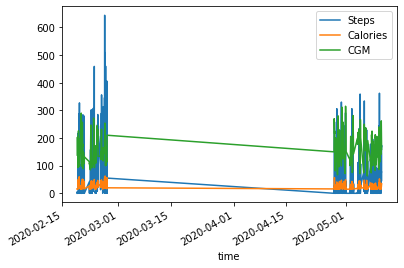

In [15]:
d = get_participant(df_intra, 39)
d.plot(x="time", y=["Steps", "Calories", "CGM"])

Alternatively, we can split the data into two different dataframes (df_before_ramanda and df_ramadan) and analyse them separately with dataprep, for example:

In [16]:
df_before_ramadan = corr_per_day(get_before_ramadan(d))
df_ramadan = corr_per_day(get_ramadan(d))

I could not spot any clear difference between the datasets:

  0%|          | 0/1480 [00:00<?, ?it/s]

DataPrep Report
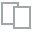
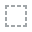
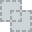
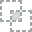
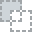
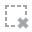
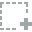
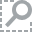
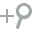
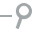
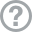
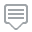
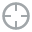
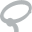
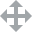
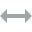
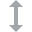
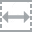
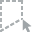
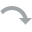
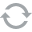
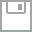
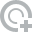
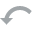
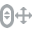
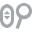
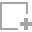
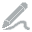
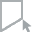
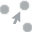
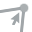
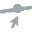

In [17]:
df_ramadan = get_before_ramadan(df_intra)
df_ramadan = ResetIndexOperator(drop=True).process(df_ramadan)[0]

if "Ramadan" in df_ramadan:
    del df_ramadan["Ramadan"]

create_report(df_ramadan)

  0%|          | 0/1480 [00:00<?, ?it/s]

DataPrep Report
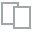
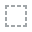
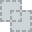
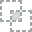
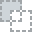
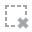
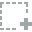
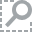
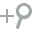
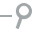
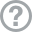
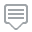
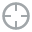
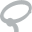
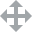
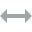
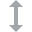
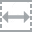
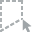
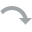
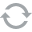
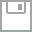
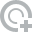
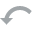
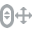
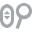
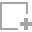
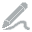
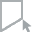
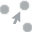
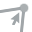
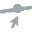

In [18]:
df_ramadan = get_ramadan(df_intra).reset_index(drop=True)

pipeline = []
pipeline.append(ResetIndexOperator(drop=True))
pipeline.append(AsTypeOperator({'hypo': int}))

pipeline = ProcessingPipeline(pipeline)
df_ramadan = pipeline.process(df_ramadan)[0]

if "Ramadan" in df_ramadan:
    del df_ramadan["Ramadan"]

create_report(df_ramadan)

## Correlation Analysis

### Correlations at user day

In [19]:
df_intra.apply(lambda x: x['time'].date(), axis=1)

1277     2020-02-17
1278     2020-02-17
1279     2020-02-17
1280     2020-02-17
1281     2020-02-17
            ...    
48604    2020-05-23
48605    2020-05-23
48606    2020-05-23
48607    2020-05-23
48608    2020-05-23
Length: 37023, dtype: object

In [20]:
def boxplot_correlation(df, secondary_col, main_col="CGM",
                        pid_col="patientID", time_col="time", 
                        remove_zero_steps=True):

    if remove_zero_steps:
        df_tmp = df[df["Steps"] > 0].copy()
    else:
        df_tmp = df.copy()

    # Get day correlation
    pipeline = ProcessingPipeline(
                [CreateFeatureOperator(feature_name='Date', 
                                       feature_creator=lambda df: df[time_col].date()),
                 GroupbyOperator(by=[pid_col, 'Date']),
                 CorrOperator(),
                 ResetIndexOperator()]
               )
    
    df_tmp = pipeline.process(df_tmp)[0]
        
    sns.set_theme(style="ticks")
        
    # Plot the orbital period with horizontal boxes
    df_tmp = df_tmp[df_tmp["level_2"] == main_col]
    df_tmp = CreateFeatureOperator(feature_name='Ramadan', 
                                   feature_creator=lambda df: ramadan_flag(df['Date'])).process(df_tmp)[0]

    g = sns.boxplot(x=pid_col, y=secondary_col, hue="Ramadan", data=df_tmp)
    sns.stripplot(x=pid_col, y=secondary_col, data=df_tmp,
                  size=4, color=".3", linewidth=0)
    
    g.set(ylabel='Pearson Correlation\n%s-%s' % (main_col, secondary_col))
    
    sns.despine(offset=10, trim=True)
    
    # Move the legend to the right side
    g.legend(title="Ramadan?", bbox_to_anchor=(1.3, 0.5), ncol=1)
    
    return g


<AxesSubplot:xlabel='patientID', ylabel='Pearson Correlation\nCGM-Steps'>

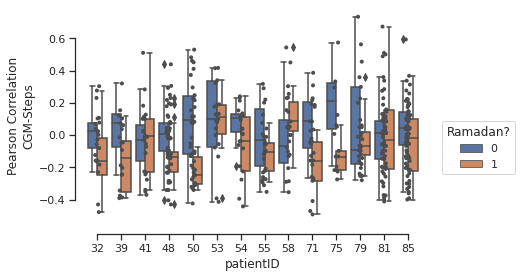

In [21]:
boxplot_correlation(df_intra, "Steps")

<AxesSubplot:xlabel='patientID', ylabel='Pearson Correlation\nCGM-Calories'>

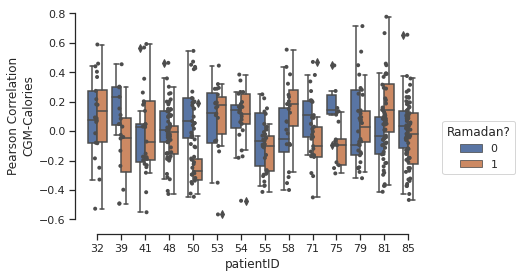

In [22]:
boxplot_correlation(df_intra, "Calories")

<AxesSubplot:xlabel='patientID', ylabel='Pearson Correlation\nCGM-HeartRate'>

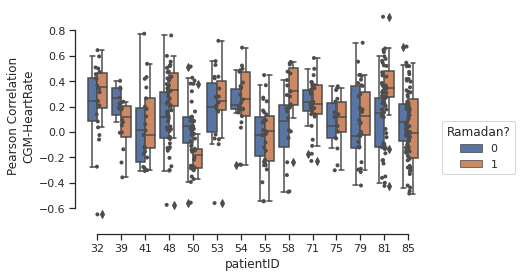

In [23]:
boxplot_correlation(df_intra, "HeartRate")

### Correlations at user level

Next, our aim is to create correlation at user level. For that, we first aggregate the data at day level (e.g., average number of steps in a day) and then average the data at user level (i.e., average number of steps per day for participant X).

For that, we will first load the EMR data and do a few data cleaning steps.

#### Load EMR data, clean and pivot it

In [24]:
df_emr = read_data(SihaEmrDataset, {SihaEmrDataset: "value"})
df_emr = PivotOperator(index="patientID", columns="variable", values="value").process(df_emr)[0]

In [25]:
df_emr = read_data(SihaEmrDataset, {SihaEmrDataset: "value"})

pipeline = ProcessingPipeline([
    PivotOperator(index="patientID", columns="variable", values="value"),
    CreateFeatureOperator(feature_name='Diabetes Duration', 
                          feature_creator=lambda df: np.nan if df['Diabetes Duration'] == '' else df['Diabetes Duration']),
    AsTypeOperator({'BMI': float,
                    'Cholesterol': float,
                    'Creatinine': float,
                    'Diabetes Duration': float,
                    'Diastolic Blood Pressure': float,
                    'HDL': float,
                    'HbA1c': float,
                    'LDL': float,
                    'Systolic Blood Pressure': float,
                   })
])

df_emr = pipeline.process(df_emr)[0]
df_emr.head()

variable    BMI  Cholesterol  Creatinine  Diabetes Duration  \
patientID                                                     
27         28.9          5.1        79.0                6.0   
30         37.8          6.4        65.0               10.0   
31         26.0          3.2        81.0               17.0   
32         33.0          NaN         NaN               11.0   
34         28.7          3.0        96.0                2.0   

variable                                 Diabetes Medication  \
patientID                                                      
27                    Sitagliptin, Glicalzide, Empagliflozin   
30         Metformin, Dapagliflozin, Sitagliptin, Pioglit...   
31         Glargine 300, Sitagliptin, Pioglitazone, Vilda...   
32                      Dapagliflozin, Sitagliptin+Metformin   
34                                Sitagliptin, Empagliflozin   

variable   Diastolic Blood Pressure  HDL  HbA1c  LDL  Systolic Blood Pressure  \
patientID                                                                       
27                             75.0  1.0    8.1  3.1                    121.0   
30                             86.0  1.1    7.8  4.5                    135.0   
31                             96.0  0.9    9.6  1.5                    134.0   
32                             77.0  NaN    7.8  NaN                    142.0   
34                             78.0  0.8   10.0  1.5                    146.0   

variable  Triglyceride  
patientID               
27                   2  
30                 1.7  
31                 1.6  
32                 NaN  
34                 1.5

In [26]:
# Tried to normalize the drug names
drugs = set([])


pipeline = ProcessingPipeline([
    ApplyOperator(lambda s: s.replace("+", ", ").split(",")),
    ApplyOperator(lambda l: [x.split()[0].strip() for x in l if x.strip()]), # This should get rid of the dosage 
                                                                #(Glargine 300 or Glargine 100 -> Glargine)
])

tmp = pipeline.process(df_emr['Diabetes Medication'])[0]

# Add drugs in df to drugs set
ApplyOperator(lambda l: [drugs.add(x) for x in l]).process(tmp)[0]



print("%d different drugs: %s" % (len(drugs), drugs))



for d in drugs:
    df_emr = CreateFeatureOperator(
                feature_name=d, 
                feature_creator=lambda df: d in df['Diabetes Medication']
             ).process(df_emr)[0]
    
df_emr.head()

14 different drugs: {'Glimepride', 'Liraglutide', 'Aspart', 'Empagliflozin', 'Sitagliptin', 'Glargine', 'Dapagliflozin', 'Exenatide', 'Vildagliptin', 'Metformin', 'Pioglitazone', 'Degludec', 'Dulaglutide', 'Glicalzide'}


variable    BMI  Cholesterol  Creatinine  Diabetes Duration  \
patientID                                                     
27         28.9          5.1        79.0                6.0   
30         37.8          6.4        65.0               10.0   
31         26.0          3.2        81.0               17.0   
32         33.0          NaN         NaN               11.0   
34         28.7          3.0        96.0                2.0   

variable                                 Diabetes Medication  \
patientID                                                      
27                    Sitagliptin, Glicalzide, Empagliflozin   
30         Metformin, Dapagliflozin, Sitagliptin, Pioglit...   
31         Glargine 300, Sitagliptin, Pioglitazone, Vilda...   
32                      Dapagliflozin, Sitagliptin+Metformin   
34                                Sitagliptin, Empagliflozin   

variable   Diastolic Blood Pressure  HDL  HbA1c  LDL  Systolic Blood Pressure  \
patientID                                                                       
27                             75.0  1.0    8.1  3.1                    121.0   
30                             86.0  1.1    7.8  4.5                    135.0   
31                             96.0  0.9    9.6  1.5                    134.0   
32                             77.0  NaN    7.8  NaN                    142.0   
34                             78.0  0.8   10.0  1.5                    146.0   

variable   ... Sitagliptin  Glargine  Dapagliflozin  Exenatide  Vildagliptin  \
patientID  ...                                                                 
27         ...        True     False          False      False         False   
30         ...        True      True           True      False         False   
31         ...        True      True          False      False          True   
32         ...        True     False           True      False         False   
34         ...        True     False          False      False         False   

variable   Metformin  Pioglitazone  Degludec  Dulaglutide  Glicalzide  
patientID                                                              
27             False         False     False        False        True  
30              True          True     False        False       False  
31              True          True     False        False       False  
32              True         False     False        False       False  
34             False         False     False        False       False  

[5 rows x 25 columns]

In [27]:
df_agg = pd.concat([mean_per_day(df_intra, "Steps", "MeanSteps", remove_zero_steps=True),
                      sum_per_day(df_intra, "Steps", "SumSteps", remove_zero_steps=True),
                      mean_per_day(df_intra, "Calories", remove_zero_steps=True),
                      sum_per_day(df_intra, "Calories", "SumCalories", remove_zero_steps=True),
                      mean_per_day(df_intra, "Distance", remove_zero_steps=True),
                      sum_per_day(df_intra, "Distance", "SumDistance", remove_zero_steps=True),
                      mean_per_day(df_intra, "mets", remove_zero_steps=True),
                      mean_per_day(df_intra, "HeartRate", remove_zero_steps=True),
                      mean_per_day(df_intra, "CGM", remove_zero_steps=True),
                      mean_per_day(df_intra, "hypo", "AvgHypo", remove_zero_steps=True),
                      sum_per_day(df_intra, "hypo", "TotalHypo", remove_zero_steps=True),
                      mean_per_day(df_intra, "hyper", "AvgHyper", remove_zero_steps=True),
                      sum_per_day(df_intra, "hyper", "TotalHyper", remove_zero_steps=True),
                      mean_per_day(df_intra, "Ramadan", "IsRamadan", remove_zero_steps=True),
                      ], axis=1)

pipeline = ProcessingPipeline([
    ResetIndexOperator(),
    GroupbyOperator(by='patientID'),
    MeanOperator(),
])

df_means = pipeline.process(df_agg)[0]
df_means

MeanSteps      SumSteps   Calories  SumCalories  Distance  \
patientID                                                               
32         121.105591   6025.333496  50.556847  2539.665771  0.059519   
39          97.832428   3463.736816  28.477617   980.619995  0.041499   
41         122.701607   4045.250000  53.818687  1906.372559  0.058185   
48         100.830505   4140.887207  27.874519  1152.474976  0.032886   
50         132.719299   5808.155762  45.185219  1956.943115  0.061840   
53         159.439255   6482.600098  35.390106  1410.535645  0.069389   
54          91.403717   3735.043457  26.850847  1038.866821  0.040586   
55         116.800636   4505.000000  25.795034   988.495728  0.049140   
58         218.499863   9890.391602  40.766090  1827.747559  0.101980   
71         155.929352   7738.321289  34.322262  1613.548340  0.068279   
75         203.678009   8164.600098  32.716160  1312.292603  0.083506   
79         279.295959  10666.235352  56.060108  2375.571045  0.128378   
81         104.274841   5039.491699  32.782314  1575.877319  0.047505   
85         122.922684   5711.133301  33.662331  1586.068604  0.056911   

           SumDistance        mets  HeartRate         CGM   AvgHypo  \
patientID                                                             
32            2.961275  340.060849  84.007599  125.269157  0.016807   
39            1.469370  287.885337  98.240784  176.231445  0.000000   
41            1.917922  381.774038  87.760277  113.726624  0.016226   
48            1.350531  283.883487  86.630280  135.871185  0.001315   
50            2.706337  326.035208  78.442734  104.788094  0.147368   
53            2.821783  309.895863  86.437775  108.562859  0.004402   
54            1.659361  266.324603  95.040970  184.292572  0.001701   
55            1.895190  275.352630  82.759323  202.774033  0.000000   
58            4.633849  355.229102  92.308319  135.520523  0.004326   
71            3.388879  328.128700  87.371445  152.607605  0.000605   
75            3.347584  332.312455  93.875122  158.329254  0.000000   
79            4.877970  400.179307  85.062363  126.495506  0.035427   
81            2.295756  273.892666  88.412552  140.713547  0.003507   
85            2.643933  284.502466  95.481247  131.117783  0.090031   

           TotalHypo  AvgHyper  TotalHyper  IsRamadan  
patientID                                              
32          0.809524  0.067380    3.333333   0.380952  
39          0.000000  0.481490   15.052632   0.631579  
41          0.458333  0.010101    0.333333   0.541667  
48          0.064516  0.099966    4.451613   0.354839  
50          6.400000  0.033342    1.488889   0.311111  
53          0.200000  0.003239    0.150000   0.700000  
54          0.086957  0.521400   19.608696   0.565217  
55          0.000000  0.730887   28.033333   0.500000  
58          0.173913  0.110313    4.913043   0.478261  
71          0.035714  0.241073   11.642857   0.464286  
75          0.000000  0.222193    9.133333   0.600000  
79          0.294118  0.089767    4.205882   0.588235  
81          0.186441  0.148340    6.983051   0.406780  
85          4.400000  0.162535    7.386667   0.413333

In [28]:
MergeOperator(left_index=True, right_index=True).process(df_means, df_emr, df_steps, df_distance)

MeanSteps      SumSteps   Calories  SumCalories  Distance_x  SumDistance  \
32  121.105591   6025.333496  50.556847  2539.665771    0.059519     2.961275   
39   97.832428   3463.736816  28.477617   980.619995    0.041499     1.469370   
48  100.830505   4140.887207  27.874519  1152.474976    0.032886     1.350531   
50  132.719299   5808.155762  45.185219  1956.943115    0.061840     2.706337   
53  159.439255   6482.600098  35.390106  1410.535645    0.069389     2.821783   
54   91.403717   3735.043457  26.850847  1038.866821    0.040586     1.659361   
55  116.800636   4505.000000  25.795034   988.495728    0.049140     1.895190   
58  218.499863   9890.391602  40.766090  1827.747559    0.101980     4.633849   
71  155.929352   7738.321289  34.322262  1613.548340    0.068279     3.388879   
75  203.678009   8164.600098  32.716160  1312.292603    0.083506     3.347584   
79  279.295959  10666.235352  56.060108  2375.571045    0.128378     4.877970   
81  104.274841   5039.491699  32.782314  1575.877319    0.047505     2.295756   

          mets  HeartRate         CGM   AvgHypo  ...  Pioglitazone  Degludec  \
32  340.060849  84.007599  125.269157  0.016807  ...         False     False   
39  287.885337  98.240784  176.231445  0.000000  ...          True     False   
48  283.883487  86.630280  135.871185  0.001315  ...         False     False   
50  326.035208  78.442734  104.788094  0.147368  ...         False     False   
53  309.895863  86.437775  108.562859  0.004402  ...          True     False   
54  266.324603  95.040970  184.292572  0.001701  ...          True     False   
55  275.352630  82.759323  202.774033  0.000000  ...         False     False   
58  355.229102  92.308319  135.520523  0.004326  ...         False     False   
71  328.128700  87.371445  152.607605  0.000605  ...          True     False   
75  332.312455  93.875122  158.329254  0.000000  ...         False      True   
79  400.179307  85.062363  126.495506  0.035427  ...         False     False   
81  273.892666  88.412552  140.713547  0.003507  ...         False      True   

    Dulaglutide  Glicalzide              time_x  patientID_x  Steps  \
32        False       False 2020-02-09 01:30:00           70    0.0   
39        False       False 2020-02-09 01:45:00           59    0.0   
48        False       False 2020-02-09 02:15:00           50    0.0   
50        False       False 2020-02-09 02:30:00           70    0.0   
53        False       False 2020-02-09 02:30:00           54    0.0   
54        False        True 2020-02-09 02:30:00           37    0.0   
55        False       False 2020-02-09 02:45:00           70    0.0   
58        False       False 2020-02-09 02:45:00           54    0.0   
71        False       False 2020-02-09 03:30:00           70    0.0   
75         True       False 2020-02-09 03:45:00           50    0.0   
79        False       False 2020-02-09 03:45:00           54    0.0   
81        False       False 2020-02-09 04:00:00           54    0.0   

                time_y patientID_y  Distance_y  
32 2020-02-09 01:30:00          70         0.0  
39 2020-02-09 01:45:00          59         0.0  
48 2020-02-09 02:15:00          50         0.0  
50 2020-02-09 02:30:00          70         0.0  
53 2020-02-09 02:30:00          54         0.0  
54 2020-02-09 02:30:00          37         0.0  
55 2020-02-09 02:45:00          70         0.0  
58 2020-02-09 02:45:00          54         0.0  
71 2020-02-09 03:30:00          70         0.0  
75 2020-02-09 03:45:00          50         0.0  
79 2020-02-09 03:45:00          54         0.0  
81 2020-02-09 04:00:00          54         0.0  

[12 rows x 45 columns]

In [29]:
df_merged = MergeOperator(left_index=True, right_index=True).process(df_means, df_emr, df_steps, df_distance)
df_merged.head()

MeanSteps     SumSteps   Calories  SumCalories  Distance_x  SumDistance  \
32  121.105591  6025.333496  50.556847  2539.665771    0.059519     2.961275   
39   97.832428  3463.736816  28.477617   980.619995    0.041499     1.469370   
48  100.830505  4140.887207  27.874519  1152.474976    0.032886     1.350531   
50  132.719299  5808.155762  45.185219  1956.943115    0.061840     2.706337   
53  159.439255  6482.600098  35.390106  1410.535645    0.069389     2.821783   

          mets  HeartRate         CGM   AvgHypo  ...  Pioglitazone  Degludec  \
32  340.060849  84.007599  125.269157  0.016807  ...         False     False   
39  287.885337  98.240784  176.231445  0.000000  ...          True     False   
48  283.883487  86.630280  135.871185  0.001315  ...         False     False   
50  326.035208  78.442734  104.788094  0.147368  ...         False     False   
53  309.895863  86.437775  108.562859  0.004402  ...          True     False   

    Dulaglutide  Glicalzide              time_x  patientID_x  Steps  \
32        False       False 2020-02-09 01:30:00           70    0.0   
39        False       False 2020-02-09 01:45:00           59    0.0   
48        False       False 2020-02-09 02:15:00           50    0.0   
50        False       False 2020-02-09 02:30:00           70    0.0   
53        False       False 2020-02-09 02:30:00           54    0.0   

                time_y patientID_y  Distance_y  
32 2020-02-09 01:30:00          70         0.0  
39 2020-02-09 01:45:00          59         0.0  
48 2020-02-09 02:15:00          50         0.0  
50 2020-02-09 02:30:00          70         0.0  
53 2020-02-09 02:30:00          54         0.0  

[5 rows x 45 columns]

In [30]:
for d in drugs:
    df_drug = df_merged[df_merged[d] == True]
    print("People in the final dataset that took drug %s: %d" % (d, df_drug.shape[0]))

People in the final dataset that took drug Glimepride: 1
People in the final dataset that took drug Liraglutide: 2
People in the final dataset that took drug Aspart: 1
People in the final dataset that took drug Empagliflozin: 2
People in the final dataset that took drug Sitagliptin: 8
People in the final dataset that took drug Glargine: 4
People in the final dataset that took drug Dapagliflozin: 5
People in the final dataset that took drug Exenatide: 0
People in the final dataset that took drug Vildagliptin: 3
People in the final dataset that took drug Metformin: 12
People in the final dataset that took drug Pioglitazone: 4
People in the final dataset that took drug Degludec: 2
People in the final dataset that took drug Dulaglutide: 1
People in the final dataset that took drug Glicalzide: 1


We are now able to compare the correlation between any number of groups.
For example, below we verify that the correlation between average CGM and HeartRate was strong for participants taking the combo of Metformin and Sitagliptin, while it was the opposite for participants not taking these drugs. 

⭐️⭐️⭐️ <b> TODO: we need to know what kind of medicament combination is important! </b> ⭐️⭐️⭐️

In [31]:
# Compared the data for the 8 people with combo ["Metformin", "Sitagliptin"] against without (4)
df_grp1 = df_merged[((df_merged["Metformin"] == True) & (df_merged["Sitagliptin"] == True))]
df_grp2 = df_merged[~((df_merged["Metformin"] == True) & (df_merged["Sitagliptin"] == True))]

print("Corr CGM-HeartRate Grp1: %.3f, Grp2: %.3f" % (df_grp1.corr()["CGM"]["HeartRate"],
                                                     df_grp2.corr()["CGM"]["HeartRate"]))

Corr CGM-HeartRate Grp1: 0.881, Grp2: -0.287


Before moving to the next section, we save a postprocessed dataframe to disk in order to speed up futher ML pipelines.

In [32]:
profast_ml = os.path.join(profast_datapath, "preprocessed")
if not os.path.exists(profast_ml):
    os.mkdir(profast_ml)

df_intra.to_csv(os.path.join(profast_ml, "data.csv.gz"), index=False)

## 2 - Machine Learning for CGM Prediction

This second part of this notebook used the preprocessed data from profast 2020 for CGM prediction.
Note that we can move this section elsewhere without problem if this notebook becomes too extense.
For that, we start by loading the preprocessed data.

In [33]:
df = pd.read_csv(os.path.join(profast_ml, "data.csv.gz"))
df["time"] = pd.to_datetime(df["time"])
df.head()

patientID                time  HeartRate  level   mets  Calories  Steps  \
0         32 2020-02-17 10:30:00  88.266670    1.0  616.0  91.58072  408.0   
1         32 2020-02-17 10:45:00  75.933334    1.0  234.0  34.78878   22.0   
2         32 2020-02-17 11:00:00  75.066666    1.0  440.0  65.41480  309.0   
3         32 2020-02-17 11:15:00  76.600000    1.0  282.0  41.92494  106.0   
4         32 2020-02-17 11:30:00  83.466670    1.0  339.0  50.39913  170.0   

   Distance    CGM  Ramadan  hypo  hyper  
0  0.200765  128.0        0     0      0  
1  0.010750  128.5        0     0      0  
2  0.151863  171.0        0     0      0  
3  0.052071  176.0        0     0      0  
4  0.083574  172.0        0     0      0

In [34]:
from sklearn.model_selection import LeaveOneGroupOut, KFold, GroupKFold

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features
from pycaret.regression import *

Next, following the idea of [this tensorflow tutorial on time_series analysis](https://www.tensorflow.org/tutorials/structured_data/time_series), we transformed time of the day into a continous sin/cos cyclic feature.

<AxesSubplot:>

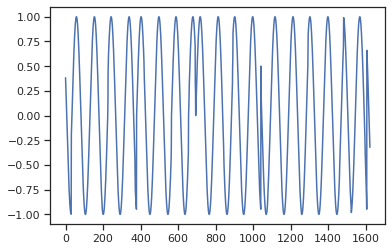

In [35]:
def convert_time_sin_cos(df, datetime_col):

    day = 24*60*60
    
    pipeline = ProcessingPipeline([
        ApplyOperator(lambda x: x.timestamp()),
        AsTypeOperator(int)
    ])
    
    ts = pipeline.process(df[datetime_col])[0]
    
    
    
    day_sin = np.sin(ts * (2 * np.pi / day))
    day_cos = np.cos(ts * (2 * np.pi / day))
    
    return day_sin, day_cos
    
    
df["time_sin"], df["time_cos"] = convert_time_sin_cos(df, "time")

df[df["patientID"] == 32]["time_sin"].plot()


In [41]:
def generate_slide_wins(df_in, start_seq=0, winsize="1h15t", time_col="time", 
                        label_col="CGM", pid_col="patientID"):
    """
    From a timeseries of ONE participant, this function generates two dataframes: <time_series_features>, <labels>
    The first dataframe can be used with tsfresh later on, while the second has all the labels that we want to predict.

    Notice that the default winsize is 1h and 15 minutres (`1h15t`).
    We used the first hour to extract the features and the 15 min only to collect the ground_truth labels.

    """
    seq_id = start_seq
    transformed_df = []
    list_of_indices = []
    labels = []
    label_times = []

    pid = df_in[pid_col].unique()
    if len(pid) > 1:
        print("ERROR: We should have only one pid here. Aborting")
        return
    pid = pid[0]
    
    df = df_in.reset_index(drop=True).copy()
    
    # The following code will construct a rolling win that could be based on either time or #win
    # This will feed list_of_indexes with the sub-win indices that will be used in the next for loop    
    pipeline = ProcessingPipeline([
        ResetIndexOperator(),
        RollingOperator(winsize, select='index', on=time_col, center=False),
        ApplyOperator((lambda x: list_of_indices.append(x.tolist()) or 0))
    ])
    
    pipeline.process(df)[0]
    
    # Time-based win might be smaller than the expected size. We fix it by comparing the size of each
    # value in the list_of_indices with the size of the last element
    max_size = len(list_of_indices[-1])

    
    for idx in list_of_indices:
        if len(idx) != max_size:
            continue

        labels.append(df.loc[idx].iloc[-1][label_col])
        label_times.append(df.loc[idx].iloc[-1][time_col])
        
        tmp_df = df.loc[idx[0:-1]].copy()
        tmp_df["seq_id"] = seq_id
        seq_id += 1

        del tmp_df[pid_col]
        
        transformed_df.append(tmp_df)

    labels = pd.Series(labels)
    labels.name = "ground_truth"
    
    label_times = pd.Series(label_times)
    label_times.name = "gt_time"
    
    transformed_df = pd.concat(transformed_df).reset_index(drop=True)
    pid = pd.Series([pid] * labels.shape[0])
    pid.name = "pid"
    
    return seq_id, transformed_df, labels, label_times, pid

In [42]:
generate_slide_wins(df.head(22), start_seq=0, winsize="3h15t")

(10,
                    time  HeartRate  level   mets  Calories  Steps  Distance  \
 0   2020-02-17 10:30:00  88.266670    1.0  616.0  91.58072  408.0  0.200765   
 1   2020-02-17 10:45:00  75.933334    1.0  234.0  34.78878   22.0  0.010750   
 2   2020-02-17 11:00:00  75.066666    1.0  440.0  65.41480  309.0  0.151863   
 3   2020-02-17 11:15:00  76.600000    1.0  282.0  41.92494  106.0  0.052071   
 4   2020-02-17 11:30:00  83.466670    1.0  339.0  50.39913  170.0  0.083574   
 5   2020-02-17 11:45:00  84.733330    1.0  458.0  68.09086  424.0  0.208656   
 6   2020-02-17 12:00:00  91.466670    0.0  216.0  32.11272    0.0  0.000000   
 7   2020-02-17 12:15:00  97.066666    1.0  422.0  62.73874  112.0  0.055116   
 8   2020-02-17 12:30:00  90.866670    1.0  446.0  66.30682  138.0  0.067792   
 9   2020-02-17 12:45:00  90.266670    1.0  445.0  66.15815  161.0  0.078976   
 10  2020-02-17 13:00:00  85.533330    1.0  324.0  48.16908   87.0  0.042688   
 11  2020-02-17 13:15:00  92.400000

Different winsizes will render different number of epochs. 
For example, if we do not have continous CGM recorded for 5 hours, we cannot generate features with a winsize bigger than 4:45min.


100%|██████████| 14/14 [00:50<00:00,  3.60s/it]


<AxesSubplot:xlabel='winsize'>

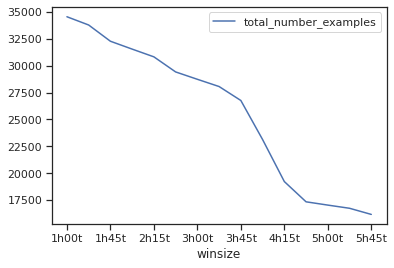

In [286]:
winsizes = ["%dh%02dt" % (hour, minute) for hour in range(1, 6) for minute in [0, 15, 45] ]

df_result = []
for winsize in winsizes:
    df_timeseries = []
    row = {}
    last_seq = 0
    for pid in tqdm(df["patientID"].unique()):
        df_tmp = df[df["patientID"] == pid]
        last_seq, df_ts_tmp, _, _, _ = generate_slide_wins(df_tmp[["patientID", "time", "CGM"]], start_seq=last_seq, winsize=winsize)
        df_timeseries.append(df_ts_tmp)
    
    row["winsize"] = winsize
    row["total_number_examples"] = last_seq
    df_result.append(row)
    
pd.DataFrame(df_result).set_index("winsize").plot()

In [203]:
signals = ["time", "patientID", "time_sin", "time_cos", 
           "HeartRate", "mets", "Calories", "Steps", "Distance", "CGM"]

winsize = "3h15t"

df_labels = []
df_label_time = []
df_timeseries = []
df_pids = []

last_seq_id = 0

for pid in tqdm(df["patientID"].unique()):

    df_tmp = df[df["patientID"] == pid]

    last_seq_id, df_ts_tmp, df_label_tmp, df_label_time_tmp, df_pid = generate_slide_wins(df_tmp[signals],
                                                                                          start_seq=last_seq_id,
                                                                                          winsize=winsize)
    df_timeseries.append(df_ts_tmp)
    df_labels.append(df_label_tmp)
    df_label_time.append(df_label_time_tmp)
    df_pids.append(df_pid)
    

df_labels = pd.concat(df_labels).reset_index(drop=True)
df_label_time = pd.concat(df_label_time).reset_index(drop=True)
df_timeseries = pd.concat(df_timeseries).reset_index(drop=True)

df_pids = pd.concat(df_pids).reset_index(drop=True)
df_pids.name = "pid"

100%|██████████| 14/14 [01:21<00:00,  5.81s/it]


In [204]:
if os.path.exists(os.path.join(profast_ml, "extracted_features_%s.csv.gz" % (winsize))):
    extracted_feature = pd.read_csv(os.path.join(profast_ml, "extracted_features_%s.csv.gz" % (winsize)))
else:
    extracted_features = extract_features(df_timeseries, column_id="seq_id", column_sort="time")
    extracted_features.to_csv(os.path.join(profast_ml, "extracted_features_%s.csv.gz" % (winsize)), index=False)

Feature Extraction: 100%|██████████| 30/30 [26:16<00:00, 52.54s/it]  


In [205]:
if os.path.exists(os.path.join(profast_ml, "filtered_features_%s.csv.gz" % (winsize))):
    features_filtered = pd.read_csv(os.path.join(profast_ml, "filtered_features_%s.csv.gz" % (winsize)))
else:
    impute(extracted_features)
    features_filtered = extract_relevant_features(df_timeseries, df_labels, column_id='seq_id', column_sort='time')
    features_filtered.to_csv(os.path.join(profast_ml, "filtered_features_%s.csv.gz" % (winsize)), index=False)

Feature Extraction: 100%|██████████| 30/30 [26:08<00:00, 52.29s/it]  


In [206]:
assert features_filtered.shape[0] == df_labels.shape[0]

In [207]:
data = pd.concat([df_pids, df_labels, features_filtered], axis=1)
data = MergeOperator(left_on="pid", right_index=True).process(data, df_emr)[0]

print("Note that there were many NAN in the ERM files.")
print("If we dropall NAN, we go from %d rows to %d (i.e., from %d to %d participants)" % (data.shape[0], 
                                                                                          data.dropna().shape[0],
                                                                                          data["pid"].unique().shape[0],
                                                                                          data.dropna()["pid"].unique().shape[0]))

print("So, lets dropping NAs...")

data = DropNAOperator().process(data)[0]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 23445 rows to 15281 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


In [208]:
# TODO: add other time relateted features (isRamadan, day_sin, day_cos)

Next we map all features to a dictionary called feature_mapping. 
Later, this will help us to build models using different feature sets.
Example ``model(data[feature_mapping["Steps"]])`` would create a model only using "Steps".

In [209]:
feature_mapping = {}
mapped_feature = set([])

for feature in signals:
    for k in data.keys():
        if k.startswith(feature):
            if feature not in feature_mapping:
                feature_mapping[feature] = []
            feature_mapping[feature].append(k)            
            mapped_feature.add(k)

feature_mapping["other"] = []
for k in data.keys():
    if k not in mapped_feature and k not in ['pid', 'ground_truth']:
        feature_mapping["other"].append(k)
            
feature_mapping

{'time': ['time_sin__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2',
  'time_sin__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
  'time_cos__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
  'time_cos__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
  'time_cos__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0',
  'time_cos__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
  'time_cos__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
  'time_cos__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2',
  'time_sin__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
  'time_sin__ar_coefficient__coeff_8__k_10',
  'time_sin__ar_coefficient__coeff_9__k_10',
  'time_cos__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0',
  'time_sin__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
  'time_cos__spkt_welch_density__coeff_2',
  'time_cos__spkt_welch_density__coeff_5',
  

In [210]:
df_emr.keys() # ["Cholesterol"]# astype(np.float)

Index(['BMI', 'Cholesterol', 'Creatinine', 'Diabetes Duration',
       'Diabetes Medication', 'Diastolic Blood Pressure', 'HDL', 'HbA1c',
       'LDL', 'Systolic Blood Pressure', 'Triglyceride', 'Glargine',
       'Sitagliptin', 'Vildagliptin', 'Glimepride', 'Pioglitazone',
       'Glicalzide', 'Empagliflozin', 'Dapagliflozin', 'Aspart', 'Exenatide',
       'Metformin', 'Dulaglutide', 'Degludec', 'Liraglutide'],
      dtype='object', name='variable')

In [211]:
data[["pid", "ground_truth"] + feature_mapping["Steps"]].head(5)

pid  ground_truth  \
1362   39         139.0   
1363   39         131.0   
1364   39         118.0   
1365   39         107.0   
1366   39          98.0   

      Steps__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)  \
1362                                           0.294926              
1363                                          -0.266882              
1364                                           0.000000              
1365                                           0.000000              
1366                                           0.000000              

      Steps__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)  \
1362                                           0.929001              
1363                                           0.294926              
1364                                          -0.266882              
1365                                           0.000000              
1366                                           0.000000              

      Steps__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)  \
1362                                          -0.266882              
1363                                           0.000000              
1364                                           0.000000              
1365                                           0.000000              
1366                                           0.000000              

      Steps__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)  \
1362                                           0.986712               
1363                                           0.000000               
1364                                           0.000000               
1365                                           0.000000               
1366                                           0.000000               

      Steps__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)  \
1362                                                0.0               
1363                                                0.0               
1364                                                0.0               
1365                                                0.0               
1366                                                0.0               

      Steps__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)  \
1362                                                0.0               
1363                                                0.0               
1364                                                0.0               
1365                                                0.0               
1366                                                0.0               

      Steps__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)  \
1362                                           1.186019               
1363                                           0.986712               
1364                                           0.000000               
1365                                           0.000000               
1366                                           0.000000               

      Steps__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)  ...  \
1362                                           1.035725              ...   
1363                                           0.000000              ...   
1364                                           0.000000              ...   
1365                                           0.000000              ...   
1366                                           0.000000              ...   

      Steps__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"  \
1362                                          -0.866025                  
1363                                          -0.866025                  
1364                                          -0.866025                  
1365                                           0.000000                  
1366                                         

In [212]:
def map_id_fold(all_ids, n, pid_col="pid"):
    
    pids = all_ids[pid_col].unique().ravel()
    if n < 0:
        n = len(pids)
    
    kf = KFold(n_splits=n, shuffle=True, random_state=42)
    mapping = []
    for i, (_, test) in enumerate(kf.split(pids)):
        for pid_index in test:
            mapping.append({'fold': i, pid_col: pids[pid_index]})

    return pd.DataFrame(mapping)

In [213]:
df_folds = map_id_fold(data, -1)
df_folds.head(10)

fold  pid
0     0   50
1     1   75
2     2   39
3     3   81
4     4   53
5     5   58
6     6   54
7     7   79

In [214]:
data = MergeOperator().process(df_folds, data)[0]
data.head()

fold  pid  ground_truth  HeartRate__quantile__q_0.1  \
0     0   50          57.5                   88.379999   
1     0   50          56.0                   91.208571   
2     0   50          56.5                   91.717139   
3     0   50          55.5                   91.390473   
4     0   50          53.0                   92.740002   

   CGM__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)  \
0                                         151.075204            
1                                         142.532703            
2                                         134.646617            
3                                         128.642634            
4                                         124.316051            

   CGM__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)  \
0                                          33.579610            
1                                          30.315396            
2                                          29.566395            
3                                          29.158376            
4                                          29.184072            

   HeartRate__quantile__q_0.8  HeartRate__quantile__q_0.7  \
0                   98.946670                   96.778098   
1                   98.946670                   96.778098   
2                   99.280002                   98.033332   
3                   99.280002                   98.033332   
4                   99.360003                   98.813333   

   HeartRate__quantile__q_0.6  HeartRate__quantile__q_0.4  ...  Pioglitazone  \
0                   96.542858                   95.920000  ...         False   
1                   96.542858                   96.426668  ...         False   
2                   96.748574                   96.480002  ...         False   
3                   96.748574                   96.480002  ...         False   
4                   97.866666                   96.528572  ...         False   

   Glicalzide  Empagliflozin  Dapagliflozin  Aspart  Exenatide  Metformin  \
0       False          False          False   False      False       True   
1       False          False          False   False      False       True   
2       False          False          False   False      False       True   
3       False          False          False   False      False       True   
4       False          False          False   False      False       True   

   Dulaglutide  Degludec  Liraglutide  
0        False     False        False  
1        False     False        False  
2        False     False        False  
3        False     False        False  
4        False     False        False  

[5 rows x 2103 columns]

In [216]:
def get_cols_by_featureset(data, featset, feature_mapping):
    acc_feats = []
    for f in featset:
        acc_feats.extend(feature_mapping[f])
        
    return ["pid", "ground_truth", "fold"] + acc_feats


In [242]:
feature_sets = [['mets', 'Calories', 'Steps', 'Distance', 'CGM'],
               ['mets', 'Calories', 'Steps', 'Distance'], 
               ['mets', 'Calories', 'Steps', 'Distance', 'CGM', 'other'],
               ['mets', 'Calories', 'Steps', 'Distance', 'other'], 
              ]

results = []
for featset in feature_sets:
    train_data = data[get_cols_by_featureset(data, featset, feature_mapping)]
    last_fold = train_data["fold"].max()
    test_data = train_data[train_data["fold"] == last_fold]
    train_data = train_data[train_data["fold"] != last_fold]
    
    cv = GroupKFold()
    
    experiment = setup(data = train_data, test_data = test_data,
                       target='ground_truth', session_id=42, silent=True,
                       fold_strategy = cv, fold_groups = 'fold',
                       fold = last_fold-1,
                       ignore_features = ["pid"]
                      )
    
    best_model = compare_models(include=['llar', 'lr', 'omp'], n_select=1)
    create_model(best_model)
    result = pull()
    
    row = {}
    row["featset"] = featset
    row["r2"] = result.loc["Mean"]["R2"]
    row["rmse"] = result.loc["Mean"]["RMSE"]
    row["name"] = best_model
    results.append(row)
    
pd.DataFrame(results)

create_model_container: 4
master_model_container: 4
display_container: 3
LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, jitter=None, max_iter=500, normalize=True,
          positive=False, precompute='auto', random_state=42, verbose=False)
create_model() succesfully completed......................................


featset      r2     rmse  \
0         [mets, Calories, Steps, Distance, CGM]  0.9598   7.7964   
1              [mets, Calories, Steps, Distance] -0.3786  46.8585   
2  [mets, Calories, Steps, Distance, CGM, other]  0.9593   7.8439   
3       [mets, Calories, Steps, Distance, other] -0.3786  46.8585   

                                                name  
0  OrthogonalMatchingPursuit(fit_intercept=True, ...  
1  LassoLars(alpha=1.0, copy_X=True, eps=2.220446...  
2  OrthogonalMatchingPursuit(fit_intercept=True, ...  
3  LassoLars(alpha=1.0, copy_X=True, eps=2.220446...